# Part 1: Rotten Tomatoes EDA
This project uses reviews from Rotten Tomatoes, the objective is to predict based on text, whether the review is fresh (1) or rotten (0).

The dataset was taken from [Kaggle](https://www.kaggle.com/mrbaloglu/rotten-tomatoes-reviews-dataset).

In [110]:
import pandas as pd 
import numpy as np 
from plotnine import *

from sklearn.feature_extraction.text import CountVectorizer
from afinn import Afinn
import matplotlib.font_manager

In [45]:
df = pd.read_csv("../data/rotten_tomatoes.csv")
df.head()

,rt_review,rt_target
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [108]:
df.shape

(10662, 7)

In [46]:
df.rt_target.value_counts()

0    5331
1    5331
Name: rt_target, dtype: int64

Great, the dataset is beautifully balanced!

## Create Additional Features
Add additional features - e.g. number of words per text, character length.

In [47]:
df['char_length'] = [len(review) for review in df['rt_review']]
df['word_count'] = [len(review.split()) for review in df['rt_review']]
df['rt_label'] = np.where(df.rt_target==0,"Rotten","Fresh")
df.head(3)

,rt_review,rt_target,char_length,word_count,rt_label
0,"simplistic , silly and tedious .",0,33,6,Rotten
1,"it's so laddish and juvenile , only teenage bo...",0,80,15,Rotten
2,exploitative and largely devoid of the depth o...,0,138,22,Rotten


In [48]:
df.describe()

,rt_target,char_length,word_count
count,10662.000000,10662.000000,10662.000000
mean,0.500000,115.156256,21.015476
std,0.500023,51.199546,9.411840
min,0.000000,5.000000,1.000000
25%,0.000000,77.000000,14.000000
50%,0.500000,112.000000,20.000000
75%,1.000000,150.000000,27.000000
max,1.000000,269.000000,59.000000


In [130]:
df[df.rt_label=='Rotten'].describe()

,rt_target,char_length,word_count,afinn_score
count,5331.0,5331.000000,5331.000000,5331.000000
mean,0.0,113.854624,20.938848,-0.068655
std,0.0,50.741268,9.369165,2.970552
min,0.0,5.000000,1.000000,-14.000000
25%,0.0,76.000000,14.000000,-2.000000
50%,0.0,111.000000,20.000000,0.000000
75%,0.0,148.000000,27.000000,2.000000
max,0.0,267.000000,56.000000,16.000000


In [131]:
df[df.rt_label=='Fresh'].describe()

,rt_target,char_length,word_count,afinn_score
count,5331.0,5331.000000,5331.000000,5331.000000
mean,1.0,116.457888,21.092103,1.984618
std,0.0,51.625705,9.454580,3.230389
min,1.0,9.000000,2.000000,-12.000000
25%,1.0,78.000000,14.000000,0.000000
50%,1.0,113.000000,20.000000,2.000000
75%,1.0,152.000000,27.000000,4.000000
max,1.0,269.000000,59.000000,22.000000


## Functions to help EDA

In [52]:
#Function to get Count Vectorized dataframe output of the dataframe
def get_cv(df, text_col, stop_words, min_df, ngram_range):
    cv = CountVectorizer(stop_words=stop_words,
                         ngram_range = ngram_range,
                         min_df= min_df)
    cv.fit(df[text_col])
    cv_text = cv.transform(df[text_col])
    df_cv = pd.DataFrame(cv_text.todense(),columns=cv.get_feature_names())
    data = pd.merge(df, df_cv, left_index=True, right_index=True)
    return data

#Function to return the name of all word columns
def get_words(df, text_col, stop_words, min_df, ngram_range):
    cv = CountVectorizer(stop_words=stop_words,
                         ngram_range = ngram_range,
                         min_df= min_df)
    cv.fit(df[text_col])
    cv_text = cv.transform(df[text_col])
    df_cv = pd.DataFrame(cv_text.todense(),columns=cv.get_feature_names())
    cols = [col for col in df_cv]
    return cols

#Function to return the top text (words or phrases) in a dataframe
def get_top_text(df, target, text_cols, top_n):
    #aggregate and flip
    data = (df[['rt_label']+text_cols]
            .groupby('rt_label')
            .sum().T[target])
    #filter out words in remove list
    remove_list = ['ve','com','nt','https']
    data = data[data.index.isin(remove_list)==False]
    data = data[data.index.str.contains("com")==False]
    #sort and return top values
    data = data.sort_values(ascending=False).head(top_n)
    return pd.DataFrame(data)

## Setting Visual Aesthetics

In [121]:
#color palette from rotten tomatoes 
red = '#FA3209'
green = '#23CB5F'
black = '#010217'

col_pal = [red,green]

font_title = 'Franklin Gothic Book'
font_family = 'Franklin Gothic'

## Visualization Distribution

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../plots/dist_char_len.png
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


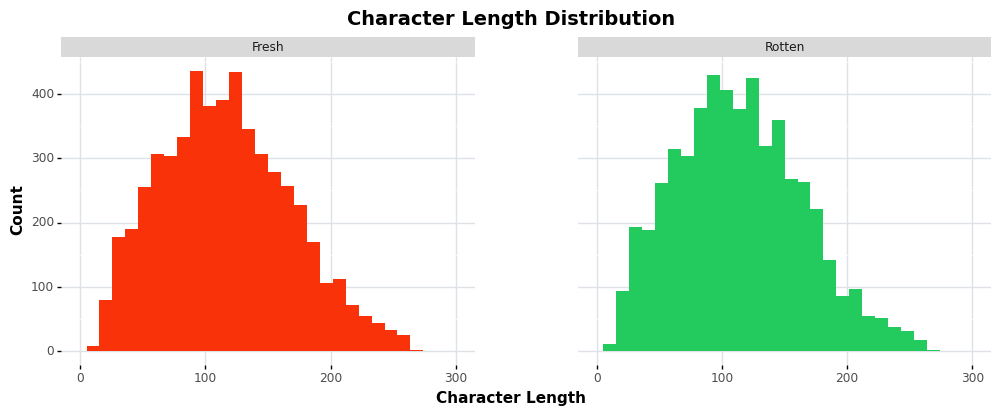

<ggplot: (8780125934981)>

In [125]:
char_len = (ggplot(df, aes(x='char_length', fill="rt_label"))
                +geom_histogram(bins=30) 
                +facet_wrap("rt_label")
                +scale_fill_manual(values=col_pal)
                +scale_x_continuous(limits=(0,300))
                + ylab("Count")
                + xlab("Character Length")
                +ggtitle("Character Length Distribution")
                +theme(figure_size=(12, 4),
                    text = element_text(family="Franklin Gothic Book"),
                    plot_title=element_text(family="Franklin Gothic", weight='bold',color='black', size=14),
                    panel_background = element_rect(fill="white"),
                    panel_grid_major = element_line(color="#dee2e6"),
                    subplots_adjust={'wspace': 0.25},
                    legend_position="none",
                    axis_title = element_text(weight='bold'))
          )


ggsave(plot=char_len, filename='../plots/dist_char_len.png', dpi=1000)

char_len

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../plots/dist_word_count.png
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


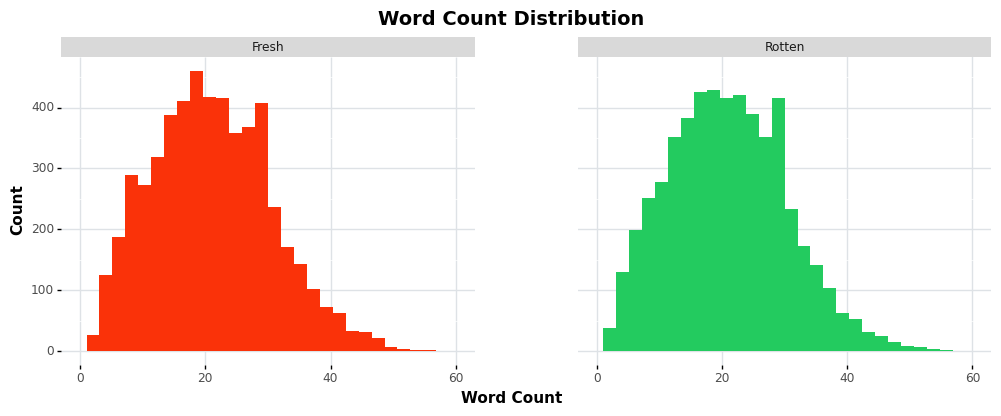

<ggplot: (8779576996100)>

In [124]:
word_count = (ggplot(df, aes(x='word_count', fill="rt_label"))
                +geom_histogram(bins=30) 
                +facet_wrap("rt_label")
                +scale_fill_manual(values=col_pal)
                +scale_x_continuous(limits=(0,60))
                + ylab("Count")
                + xlab("Word Count")
                +ggtitle("Word Count Distribution")
                +theme(figure_size=(12, 4),
                    text = element_text(family=font_family),
                    plot_title=element_text(family=font_title, weight='bold',color='black', size=14),
                    panel_background = element_rect(fill="white"),
                    panel_grid_major = element_line(color="#dee2e6"),
                    subplots_adjust={'wspace': 0.25},
                    legend_position="none",
                    axis_title = element_text(weight='bold'))
          )

ggsave(plot=word_count, filename='../plots/dist_word_count.png', dpi=1000)

word_count


## Create Data Set to Visualize Words

### Top Words

In [54]:
words = get_cv(df, 'rt_review', 'english', 2, (1,1))
word_list = get_words(df, 'rt_review', 'english', 2, (1,1))

In [58]:
#popular words for fresh reviews
top_words_fresh = get_top_text(words, 'Fresh', word_list, 15).rename(columns={'Fresh':"count"})
top_words_fresh = top_words_fresh.reset_index().rename(columns={"index":"word"})
top_words_fresh['label'] = 'Fresh'

#popular words for subreddit 2
top_words_rotten = get_top_text(words, 'Rotten', word_list, 15).rename(columns={'Rotten':"count"})
top_words_rotten = top_words_rotten.reset_index().rename(columns={"index":"word"})
top_words_rotten['label'] = 'Rotten'

#combine data
top_words = pd.concat([top_words_fresh,top_words_rotten]).sort_values(by=['label','count'], ascending=False)
top_words= top_words.reset_index()

#are there common words included in both
top_words['shared'] = np.where(top_words.duplicated(subset="word", keep=False),"Shared Word","")

#used to help properly sort words/phrases in plotnine, reorders shared words/phrases, workaround
top_words['fake_suffix'] = np.where(top_words.label == 'Fresh', ""," ")

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../plots/top_words.png
findfont: Font family ['Franklin Gothic'] not found. Falling back to DejaVu Sans.


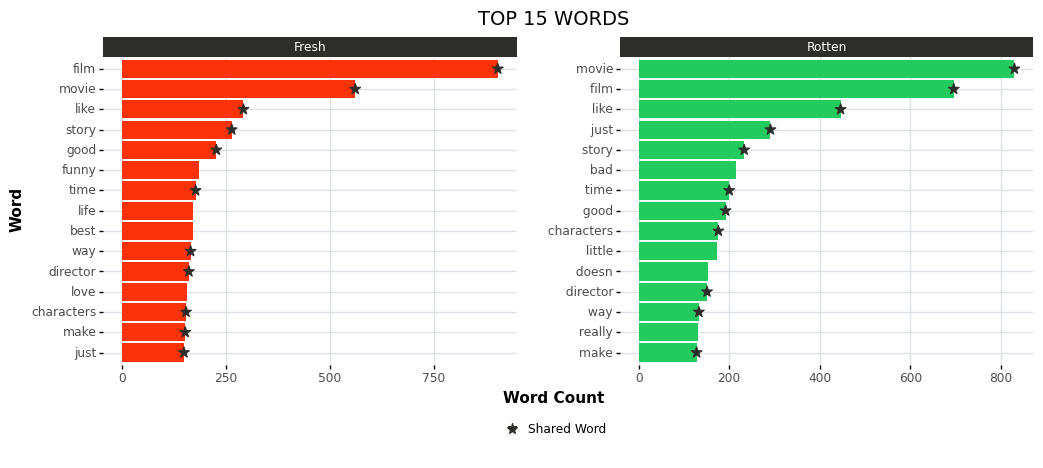

<ggplot: (8780126366501)>

In [123]:
top_words_plot = (
    ggplot(top_words, aes(y= "count", x= "reorder(fake_suffix+word,count)", fill='label'))
        + geom_bar(stat = "identity")
        + geom_point(data = top_words[top_words.shared=="Shared Word"], 
                     mapping=aes(y="count", x="fake_suffix+word",shape="shared"), 
                     color='#2D2D2A', fill="#2D2D2A",size=4)
        + xlab("Word")
        + ylab("Word Count")
        + facet_wrap("label", scales="free")
        + scale_x_discrete() 
        + scale_fill_manual(values = col_pal, guide=None)
        + scale_shape_manual(values="*", guide = guide_legend(title=""))
        + coord_flip()
        + ggtitle("TOP 15 WORDS")
        + theme(figure_size=(12, 4),
            text = element_text(family=font_family),
            plot_title=element_text(family=font_title, color='black', size=14),
            panel_background = element_rect(fill="white"),
            panel_grid_major = element_line(color="#dee2e6"),
            legend_position="bottom", legend_box_spacing=.15, legend_key=element_blank(),
            strip_background = element_rect(fill="#2D2D2A"),
            strip_text=element_text(color="white"),
            subplots_adjust={'wspace': 0.25},
            axis_title = element_text(weight='bold'))
          )

top_words_plot

ggsave(plot=top_words_plot, filename='../plots/top_words.png', dpi=1000)

top_words_plot

### Top Bigrams

In [60]:
bigram = get_cv(df, 'rt_review', 'english', 2, (2,2))
bigram_list = get_words(df, 'rt_review', 'english', 2, (2,2))

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [62]:
top_bis_fresh = pd.DataFrame(get_top_text(bigram, 'Fresh', bigram_list, 15)).rename(columns={'Fresh':"count"})
top_bis_fresh = top_bis_fresh.reset_index().rename(columns={"index":"phrase"})
top_bis_fresh['label'] = 'Fresh'

top_bis_rotten = pd.DataFrame(get_top_text(bigram, 'Rotten', bigram_list, 15)).rename(columns={'Rotten':"count"})
top_bis_rotten = top_bis_rotten.reset_index().rename(columns={"index":"phrase"})
top_bis_rotten['label'] = 'Rotten'

top_bis = pd.concat([top_bis_fresh,top_bis_rotten]).sort_values(by=['label','count'], ascending=False)
top_bis= top_bis.reset_index()

#are there common words included in both
top_bis['shared'] = np.where(top_bis.duplicated(subset="phrase", keep=False),"Shared Phrase","")

#used to help properly sort words/phrases in plotnine, reorders shared words/phrases, workaround
top_bis['fake_suffix'] = np.where(top_bis.label == 'Fresh', ""," ")

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../plots/top_bis.png


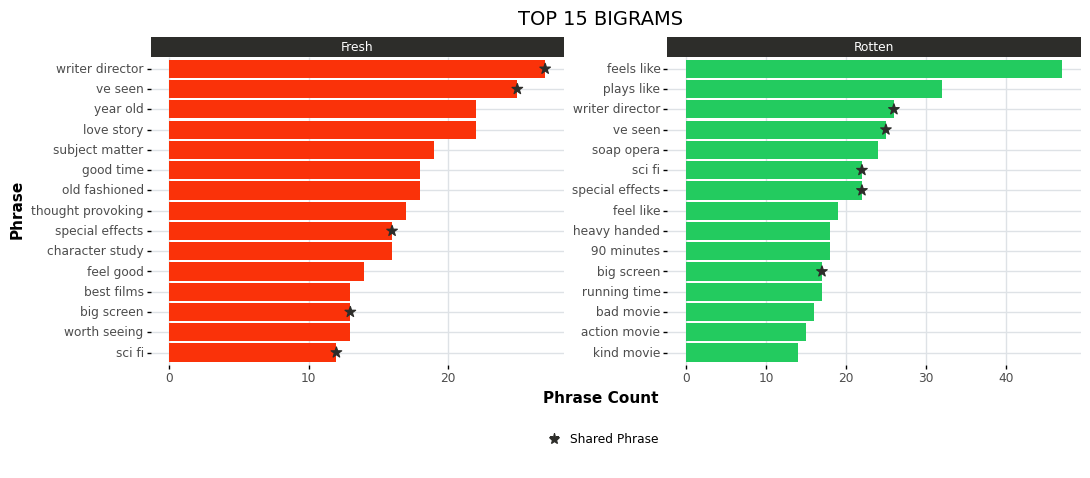

<ggplot: (8779577563838)>

In [126]:
top_bis_plot = (
    ggplot(top_bis, aes(y= "count", x= "reorder(fake_suffix+phrase,count)", fill='label'))
        + geom_bar(stat = "identity")
        + geom_point(data = top_bis[top_bis.shared=="Shared Phrase"], 
                     mapping=aes(y="count", x="fake_suffix+phrase",shape="shared"), 
                     color='#2D2D2A', fill="#2D2D2A",size=4)
        + xlab("Phrase")
        + ylab("Phrase Count")
        + facet_wrap("label", scales="free")
        + scale_x_discrete() 
        + scale_fill_manual(values = col_pal, guide=None)
        + scale_shape_manual(values="*", guide = guide_legend(title=""))
        + coord_flip()
        + ggtitle("TOP 15 BIGRAMS")
        + theme(figure_size=(12, 4),
            text = element_text(family=font_family),
            plot_title=element_text(family=font_title, color='black', size=14),
            panel_background = element_rect(fill="white"),
            panel_grid_major = element_line(color="#dee2e6"),
            legend_position="bottom", legend_box_spacing=.25, legend_key=element_blank(),
            strip_background = element_rect(fill="#2D2D2A"),
            strip_text=element_text(color="white"),
            subplots_adjust={'wspace': 0.25},
            axis_title = element_text(weight='bold'))
          )

ggsave(plot=top_bis_plot, filename='../plots/top_bis.png', dpi=1000)


top_bis_plot

## Sentiment Analysis

In [83]:
afinn = Afinn(language='en')
afinn.score('I love it but i was disappointed haha')

4.0

In [99]:
df['afinn_score'] = [afinn.score(review) for review in df['rt_review']]

In [100]:
df['afinn_type'] = np.where(df['afinn_score']>0,"Positive","Negative")
df.head(3)

,rt_review,rt_target,char_length,word_count,rt_label,afinn_score,afinn_type
0,"simplistic , silly and tedious .",0,33,6,Rotten,-1.0,Negative
1,"it's so laddish and juvenile , only teenage bo...",0,80,15,Rotten,4.0,Positive
2,exploitative and largely devoid of the depth o...,0,138,22,Rotten,-3.0,Negative


In [88]:
df.groupby('rt_label')['afinn_score'].mean()

rt_label
Fresh     1.984618
Rotten   -0.068655
Name: afinn_score, dtype: float64

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 4 in image.
/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../plots/sentiment.png


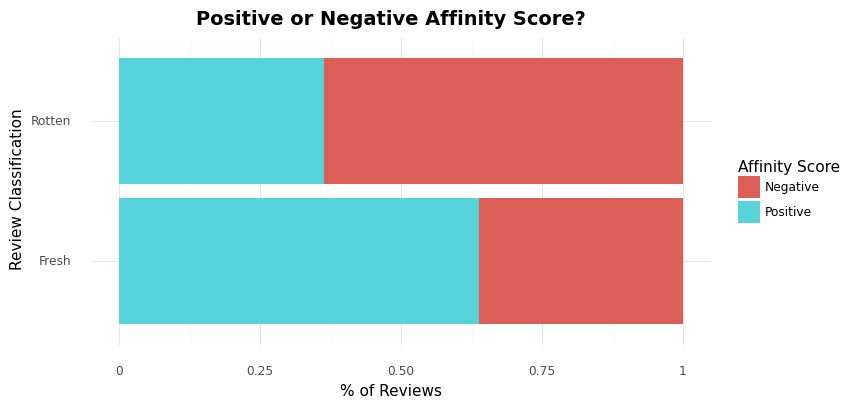

<ggplot: (8779577563835)>

In [129]:
 sentiment = (ggplot(df, aes(x="rt_label", fill="afinn_type"))
 +geom_bar(position="fill")
 +coord_flip()
 +xlab("Review Classification")
 +ylab("% of Reviews")
 +ggtitle("Positive or Negative Affinity Score?")
 +labs(fill="Affinity Score")
 +theme_minimal()
 +theme(figure_size=(8, 4),
                    text = element_text(family=font_family),
                    plot_title=element_text(weight='bold',font=font_title, color='black', size=14)
       )
)
    
    
ggsave(plot=sentiment, filename='../plots/sentiment.png', dpi=1000)


sentiment

In [90]:
df.describe()

,rt_target,char_length,word_count,afinn_score
count,10662.000000,10662.000000,10662.000000,10662.000000
mean,0.500000,115.156256,21.015476,0.957982
std,0.500023,51.199546,9.411840,3.268482
min,0.000000,5.000000,1.000000,-14.000000
25%,0.000000,77.000000,14.000000,-1.000000
50%,0.500000,112.000000,20.000000,1.000000
75%,1.000000,150.000000,27.000000,3.000000
max,1.000000,269.000000,59.000000,22.000000


In [106]:
df.to_csv("../data/rt_new_features.csv", index=False)